In [7]:
# Huấn luyện ResNet50
import os, torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

# ==== 1. Cấu hình chung ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
batch_size = 64
epochs = 10
lr = 1e-4

# ==== 2. Tiền xử lý dữ liệu ====
train_tf = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
valid_tf = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_root = r"D:/archive/jpg/train/jpg"
valid_root = r"D:/archive/jpg/valid/jpg"

train_ds = datasets.ImageFolder(train_root, transform=train_tf)
valid_ds = datasets.ImageFolder(valid_root, transform=valid_tf)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)

# ==== 3. Mô hình ====
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Chỉ fine-tune layer4 + fully connected
for name, param in model.named_parameters():
    param.requires_grad = ("layer4" in name) or ("fc" in name)

model.fc = nn.Linear(model.fc.in_features, len(train_ds.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)
scaler = GradScaler()

# ==== 4. Huấn luyện ====
best_acc = 0.0

patience, patience_counter = 5, 0

for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_loss = running_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad(), autocast():
        for images, labels in valid_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    scheduler.step(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # --- Lưu model tốt nhất ---
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50.pth")
        print(f"✅ Lưu model tốt nhất (Val Acc: {best_acc:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹ Dừng sớm (early stopping).")
            break

print("🎉 Huấn luyện hoàn tất. Best Validation Acc:", best_acc)


C:\Users\tungv\AppData\Local\Temp\ipykernel_2152\3362122776.py:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\tungv\AppData\Local\Temp\ipykernel_2152\3362122776.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\tungv\AppData\Local\Temp\ipykernel_2152\3362122776.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch [1/10] | Loss: 2.4187 | Train Acc: 0.5169 | Val Acc: 0.8374
✅ Lưu model tốt nhất (Val Acc: 0.8374)
Epoch [2/10] | Loss: 0.5137 | Train Acc: 0.9112 | Val Acc: 0.9181
✅ Lưu model tốt nhất (Val Acc: 0.9181)
Epoch [3/10] | Loss: 0.1609 | Train Acc: 0.9776 | Val Acc: 0.9438
✅ Lưu model tốt nhất (Val Acc: 0.9438)
Epoch [4/10] | Loss: 0.0612 | Train Acc: 0.9934 | Val Acc: 0.9450
✅ Lưu model tốt nhất (Val Acc: 0.9450)
Epoch [5/10] | Loss: 0.0348 | Train Acc: 0.9962 | Val Acc: 0.9413
Epoch [6/10] | Loss: 0.0202 | Train Acc: 0.9986 | Val Acc: 0.9487
✅ Lưu model tốt nhất (Val Acc: 0.9487)
Epoch [7/10] | Loss: 0.0174 | Train Acc: 0.9983 | Val Acc: 0.9499
✅ Lưu model tốt nhất (Val Acc: 0.9499)
Epoch [8/10] | Loss: 0.0174 | Train Acc: 0.9974 | Val Acc: 0.9413
Epoch [9/10] | Loss: 0.0228 | Train Acc: 0.9969 | Val Acc: 0.9462
Epoch [10/10] | Loss: 0.0087 | Train Acc: 0.9995 | Val Acc: 0.9438
🎉 Huấn luyện hoàn tất. Best Validation Acc: 0.9498777506112469


In [ ]:
#Triết xuất đặc trưng HOG từ ảnh sử dụng scikit-image
from skimage.feature import hog
from skimage import io, color
import numpy as np
import os, random

# Đường dẫn ảnh
img_dir = r"D:\archive\jpg\test"
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
sample_file = random.choice(img_files)
img_path = os.path.join(img_dir, sample_file)

# Đọc và chuyển sang grayscale
image = io.imread(img_path)
gray = color.rgb2gray(image)

# Trích xuất HOG
features, hog_image = hog(gray, pixels_per_cell=(8,8), cells_per_block=(2,2),
                          block_norm='L2-Hys', visualize=True)

print("Kích thước vector đặc trưng HOG:", features.shape)
#Đặc trưng màu (Color Histogram)
from PIL import Image
img = Image.open(img_path).convert('RGB')
hist = img.histogram()  # 256 giá trị mỗi kênh, tổng 768 chiều
features_color = np.array(hist) / sum(hist)  # Chuẩn hóa
print("Kích thước vector đặc trưng màu:", features_color.shape)
#Kết hợp đặc trưng HOG và màu sắc
features_combined = np.concatenate((features, features_color))
print("Kích thước vector đặc trưng kết hợp:", features_combined.shape)


Kích thước vector đặc trưng HOG: (149328,)
Kích thước vector đặc trưng màu: (768,)
Kích thước vector đặc trưng kết hợp: (150096,)


🔄 Trích xuất đặc trưng...
Train features: (6552, 2048) Valid features: (818, 2048)
✅ K-NN Accuracy: 0.7408
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       1.00      1.00      1.00         4
           2       0.83      0.83      0.83         6
           3       0.29      0.40      0.33         5
           4       1.00      0.67      0.80         6
           5       0.38      0.50      0.43        10
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         1
           9       0.88      1.00      0.93         7
          10       1.00      1.00      1.00         2
          11       0.88      0.88      0.88        16
          12       0.37      0.64      0.47        11
          13       0.50      0.50      0.50         4
          14       1.00      1.00      1.00         6
          15       1.00     

d:\New folder (2)\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder (2)\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\New folder (2)\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


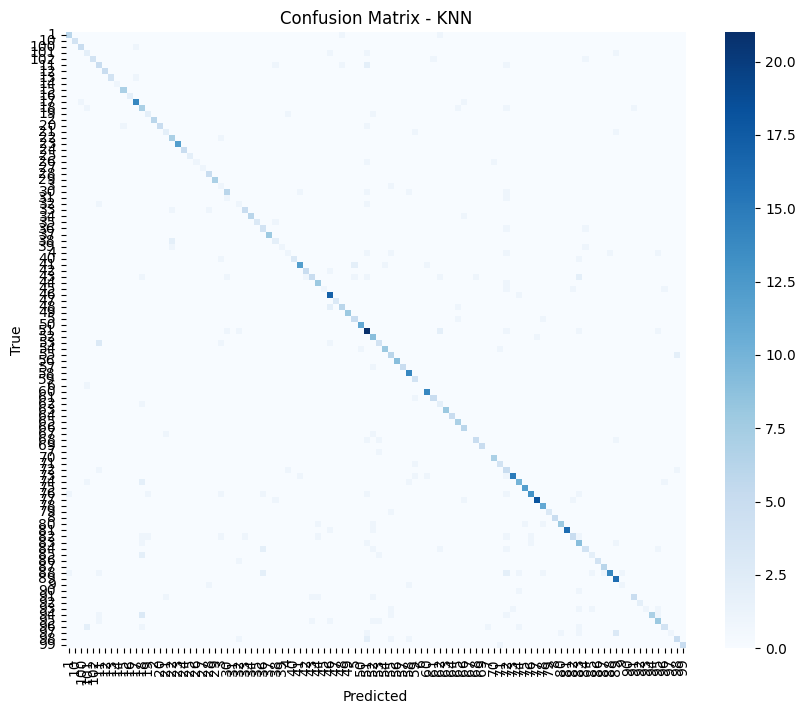

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 1. Tiền xử lý =====
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

train_root = r'D:/archive/jpg/train/jpg'
valid_root = r'D:/archive/jpg/valid/jpg'
train_data = datasets.ImageFolder(train_root, transform=transform)
valid_data = datasets.ImageFolder(valid_root, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 2. Tải ResNet50 pre-trained và bỏ lớp FC =====
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1]).to(device)
feature_extractor.eval()

def extract_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            out = feature_extractor(imgs)       # shape: (batch, 2048, 1, 1)
            out = out.view(out.size(0), -1)     # shape: (batch, 2048)
            features.append(out.cpu().numpy())
            labels.extend(lbls.numpy())
    return np.concatenate(features), np.array(labels)

print("🔄 Trích xuất đặc trưng...")
X_train, y_train = extract_features(train_loader)
X_valid, y_valid = extract_features(valid_loader)

print("Train features:", X_train.shape, "Valid features:", X_valid.shape)

# ===== 3. Huấn luyện K-NN =====
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

# ===== 4. Dự đoán và đánh giá =====
y_pred = knn.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
print(f"✅ K-NN Accuracy: {acc:.4f}")
print(classification_report(y_valid, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


d:\New folder (2)\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📌 Accuracy: 0.9487
📌 Precision: 0.9540
📌 Recall: 0.9487
📌 F1-score: 0.9486

🔎 Báo cáo chi tiết:
              precision    recall  f1-score   support

           1       0.89      1.00      0.94         8
          10       1.00      1.00      1.00         4
         100       1.00      1.00      1.00         6
         101       1.00      1.00      1.00         5
         102       1.00      1.00      1.00         6
          11       0.78      0.70      0.74        10
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         1
          15       0.78      1.00      0.88         7
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00        16
          18       1.00      0.82      0.90        11
          19       0.75      0.75      0.75         4
           2       1.00      1.00      1.00         6
          20       0.88      1.00      

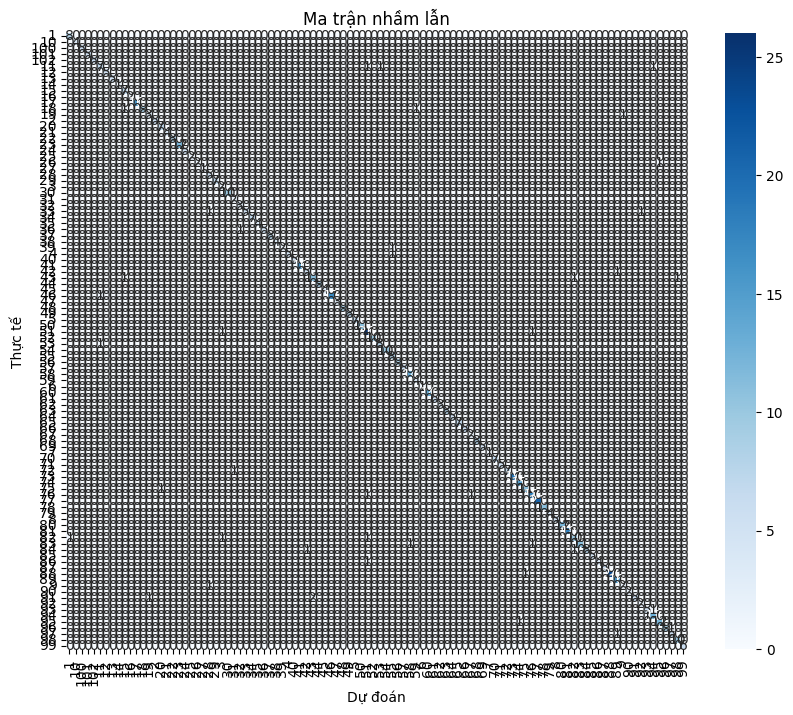

In [27]:
#Đánh giá mô hình với ảnh ngẫu nhiên
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# === Đánh giá mô hình trên tập validation ===
model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# === 1.1. Tính các metrics ===
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"📌 Accuracy: {acc:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-score: {f1:.4f}")
print("\n🔎 Báo cáo chi tiết:")
print(classification_report(all_labels, all_preds, target_names=valid_ds.classes))
# === 1.2. Ma trận nhầm lẫn ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid_ds.classes, yticklabels=valid_ds.classes)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn')
plt.show()



In [ ]:
# Giả sử bạn đã có train_generator và test_generator của Oxford Flowers 102
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    'D:/archive/jpg/train/jpg',
    target_size=(224,224),
    batch_size=32,
    subset='training',
    shuffle=True)

val_generator = datagen.flow_from_directory(
    'D:/archive/jpg/valid/jpg',
    target_size=(224,224),
    batch_size=32,
    subset='validation',
    shuffle=False)

# Test có thể dùng validation hoặc tách riêng thư mục
test_generator = val_generator

# Dùng ResNet50 để trích xuất đặc trưng
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
# Hàm trích xuất đặc trưng từ generator
def extract_features(generator, model):
    features = model.predict(generator)
    labels = generator.classes
    return features, labels

# Remove the erroneous model.fit here, as model is not defined yet

train_generator=train_generator
valid_generator=val_generator
X_train_feat, y_train = extract_features(train_generator, base_model)
X_test_feat, y_test = extract_features(test_generator, base_model)

# Huấn luyện K-NN trên đặc trưng
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_feat, y_train)

# 📌 Dự đoán với K-NN
y_pred_knn = knn.predict(X_test_feat)

# Fine-tune ResNet50
x = base_model.output
x = Dense(512, activation='relu')(x)
preds = Dense(102, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)
train_generator=train_generator
valid_generator=val_generator


for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=10)

# 📌 Dự đoán với ResNet50
predictions = model.predict(test_generator)
y_pred_resnet = np.argmax(predictions, axis=1)
y_test_resnet = test_generator.classes
#Tính chỉ số Accuracy và F1-score cho cả hai phương pháp
from sklearn.metrics import accuracy_score, f1_score

acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='macro')

acc_resnet = accuracy_score(y_test_resnet, y_pred_resnet)
f1_resnet = f1_score(y_test_resnet, y_pred_resnet, average='macro')

methods = ['K-NN', 'ResNet50']
accuracy = [acc_knn, acc_resnet]
f1_scores = [f1_knn, f1_resnet]

for m, acc, f1 in zip(methods, accuracy, f1_scores):
    print(f"{m}: Accuracy={acc:.3f}, F1-score={f1:.3f}")
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(methods))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, accuracy, width, label='Accuracy')
plt.bar(x + width/2, f1_scores, width, label='F1-score')

plt.xticks(x, methods)
plt.ylim(0,1)
plt.ylabel('Scores')
plt.title('So sánh hiệu suất K-NN và ResNet50 (Oxford Flowers 102)')
plt.legend()
plt.show()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_resnet, y_pred_resnet)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(10,10))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - ResNet50')
plt.show()




Found 5283 images belonging to 102 classes.
Found 125 images belonging to 102 classes.


d:\New folder (2)\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 72/166 ━━━━━━━━━━━━━━━━━━━━ 4:37 3s/step

KeyboardInterrupt: 

In [ ]:
#Học chuyển giao
import random   
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os

# Kiểm tra đường dẫn ảnh
img_dir = r"D:\archive\jpg\test"
img_path=os.path.join(img_dir, random.choice(os.listdir(img_dir)))
assert os.path.exists(img_path), f"Không tìm thấy ảnh: {img_path}"

# Thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet50 pre-trained, bỏ fc layer
if hasattr(models, "ResNet50_Weights"):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
else:
    model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval().to(device)

# Tiền xử lý
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# Đọc và chuẩn hóa ảnh
img = Image.open(img_path).convert('RGB')
img_t = transform(img).unsqueeze(0).to(device)  # shape (1,3,224,224)

# Trích xuất đặc trưng
with torch.no_grad():
    features_resnet = model(img_t).flatten(1).cpu().numpy()  # shape (1,2048)

print("Kích thước vector đặc trưng ResNet:", features_resnet.shape)


Kích thước vector đặc trưng ResNet: (1, 2048)


In [1]:
#Kiểm tra dữ liệu trong tập
import os, scipy.io as sio

# Kiểm tra tồn tại file nhãn và thư mục ảnh
label_path = r"D:\archive\imagelabels.mat"
img_dir = r"D:\archive\jpg\train\jpg"

print("Có nhãn:", os.path.exists(label_path))
print("Có thư mục ảnh:", os.path.exists(img_dir))

# Liệt kê một số file ảnh đầu
files = sorted(os.listdir(img_dir))[:10]
print("10 file đầu:", files)

# Đọc nhãn và kiểm tra dạng dữ liệu
labels = sio.loadmat(label_path)['labels'][0]
print("Số lượng nhãn:", len(labels))
print("Dạng dữ liệu nhãn:", labels.dtype)
print("5 nhãn đầu:", labels[:5])


Có nhãn: True
Có thư mục ảnh: True
10 file đầu: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15']
Số lượng nhãn: 8189
Dạng dữ liệu nhãn: uint8
5 nhãn đầu: [77 77 77 77 77]


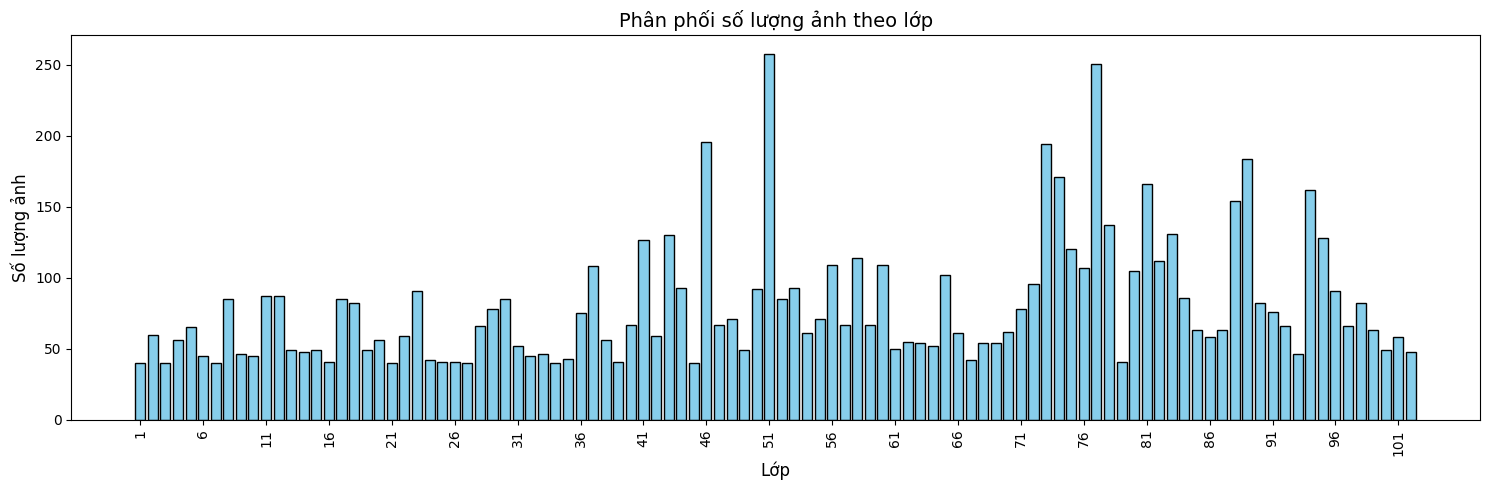

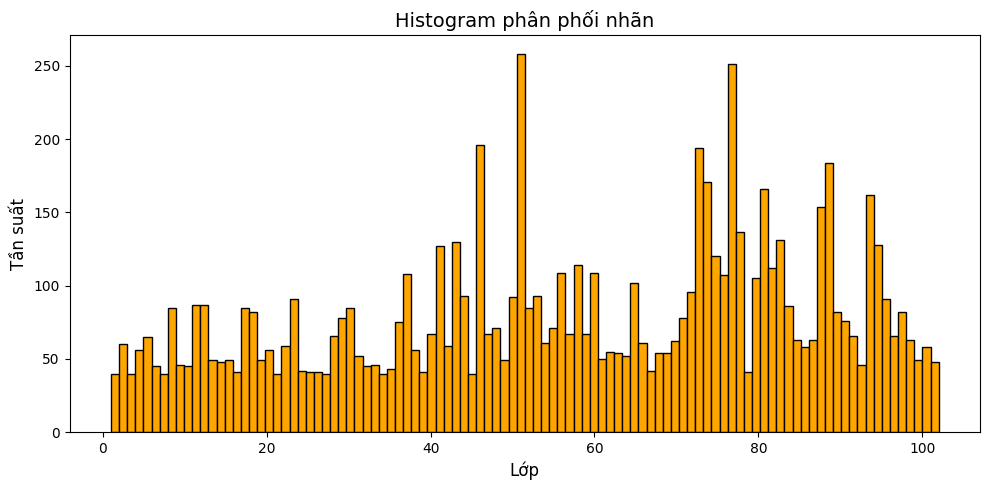

In [19]:
#Trực quan hóa phân phối nhãn
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Giả sử biến `labels` đã được load từ file .mat trước đó
counts = Counter(labels)  # Đếm số lượng ảnh trong mỗi lớp
classes = sorted(counts.keys())
values = [counts[c] for c in classes]

# Biểu đồ thanh phân phối nhãn
plt.figure(figsize=(15,5))
plt.bar(classes, values, color='skyblue', edgecolor='black')
plt.xlabel('Lớp', fontsize=12)
plt.ylabel('Số lượng ảnh', fontsize=12)
plt.title('Phân phối số lượng ảnh theo lớp', fontsize=14)
plt.xticks(np.arange(min(classes), max(classes)+1, step=max(1, len(classes)//20)), rotation=90)
plt.tight_layout()
plt.show()

# Hoặc vẽ histogram đơn giản (hữu ích nếu có rất nhiều lớp)
plt.figure(figsize=(10,5))
plt.hist(labels, bins=len(classes), color='orange', edgecolor='black')
plt.xlabel('Lớp', fontsize=12)
plt.ylabel('Tần suất', fontsize=12)
plt.title('Histogram phân phối nhãn', fontsize=14)
plt.tight_layout()
plt.show()


✅ Thư mục ảnh tồn tại: D:\archive\jpg\train\1
Số lớp có ảnh (1) ít hơn số cần hiển thị (5), sẽ hiển thị tất cả lớp có ảnh.


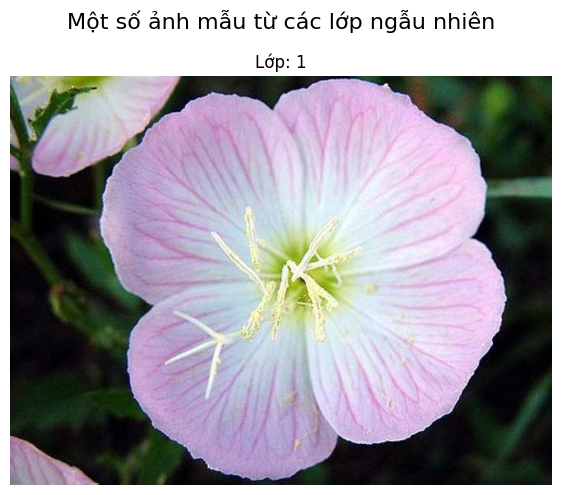

In [ ]:
#Trực quan hóa ảnh mẫu từ nhiều lớp khác nhau
import matplotlib.pyplot as plt
import numpy as np
import random, os
from PIL import Image
from collections import defaultdict
# Giả sử biến `labels` đã được load từ file .mat và thư mục ảnh nằm trong `img_dir`
img_dir = r"D:\archive\jpg\test"  # Cập nhật đường dẫn thư mục ảnh nếu cần
if not os.path.exists(img_dir):
    raise FileNotFoundError(f"❌ Thư mục không tồn tại: {img_dir}")
print(f"✅ Thư mục ảnh tồn tại: {img_dir}")
# Ánh xạ lớp → danh sách ảnh thuộc lớp đó
class_to_images = defaultdict(list)
for file in os.listdir(img_dir):
    if file.lower().endswith(('.jpg','.jpeg','.png')):
        idx = int(file.split('_')[-1].split('.')[0]) - 1  # Lấy chỉ số từ tên ảnh
        class_to_images[labels[idx]].append(file)
# Chọn ngẫu nhiên N lớp và hiển thị một ảnh đại diện cho mỗi lớp
num_classes_to_show = 5
# Lọc các lớp có ít nhất 1 ảnh
non_empty_classes = [cls for cls, imgs in class_to_images.items() if imgs]
if num_classes_to_show > len(non_empty_classes):
    print(f"Số lớp có ảnh ({len(non_empty_classes)}) ít hơn số cần hiển thị ({num_classes_to_show}), sẽ hiển thị tất cả lớp có ảnh.")
    num_classes_to_show = len(non_empty_classes)
chosen_classes = random.sample(non_empty_classes, num_classes_to_show)
plt.figure(figsize=(15,5))
for i, cls in enumerate(chosen_classes):
    if not class_to_images[cls]:
        continue
    sample_file = random.choice(class_to_images[cls])
    img_path = os.path.join(img_dir, sample_file)
    try:
        img = Image.open(img_path)
        plt.subplot(1, num_classes_to_show, i+1)
        plt.imshow(img)
        plt.title(f"Lớp: {cls}")
        plt.axis('off')
    except Exception as e:
        print(f"⚠ Lỗi khi đọc ảnh {sample_file}: {e}")
plt.suptitle("Một số ảnh mẫu từ các lớp ngẫu nhiên", fontsize=16)
plt.tight_layout()
plt.show()



In [ ]:
#Chuẩn hóa ảnh:Resize + Pixel Normalization
from PIL import Image
import numpy as np
import os
import random
# Đường dẫn thư mục ảnh
img_dir = r"D:\archive\jpg\test"
# Kích thước chuẩn mong muốn (ví dụ: 224x224)
target_size = (224, 224)
# Lấy một số file ảnh để minh họa
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
sample_files = random.sample(img_files, min(5, len(img_files)))
normalized_images = []  # Danh sách ảnh chuẩn hóa
for file in sample_files:
    img_path = os.path.join(img_dir, file)
    try:
        # Mở và resize ảnh
        img = Image.open(img_path).convert('RGB')  # Đảm bảo 3 kênh màu
        img = img.resize(target_size)
        # Chuyển sang mảng NumPy và chuẩn hóa giá trị pixel về [0, 1]
        img_array = np.array(img) / 255.0
        normalized_images.append(img_array)
        print(f"Ảnh {file}: Kích thước sau resize {img_array.shape}, "
              f"Giá trị pixel min={img_array.min():.3f}, max={img_array.max():.3f}")
    except Exception as e:
        print(f"⚠ Lỗi khi xử lý ảnh {file}: {e}")
print(f"Tổng số ảnh đã chuẩn hóa: {len(normalized_images)}")

Ảnh image_01650.jpg: Kích thước sau resize (224, 224, 3), Giá trị pixel min=0.000, max=1.000
Ảnh image_06498.jpg: Kích thước sau resize (224, 224, 3), Giá trị pixel min=0.000, max=1.000
Ảnh image_08129.jpg: Kích thước sau resize (224, 224, 3), Giá trị pixel min=0.000, max=1.000
Ảnh image_01109.jpg: Kích thước sau resize (224, 224, 3), Giá trị pixel min=0.000, max=1.000
Ảnh image_03510.jpg: Kích thước sau resize (224, 224, 3), Giá trị pixel min=0.000, max=1.000
Tổng số ảnh đã chuẩn hóa: 5


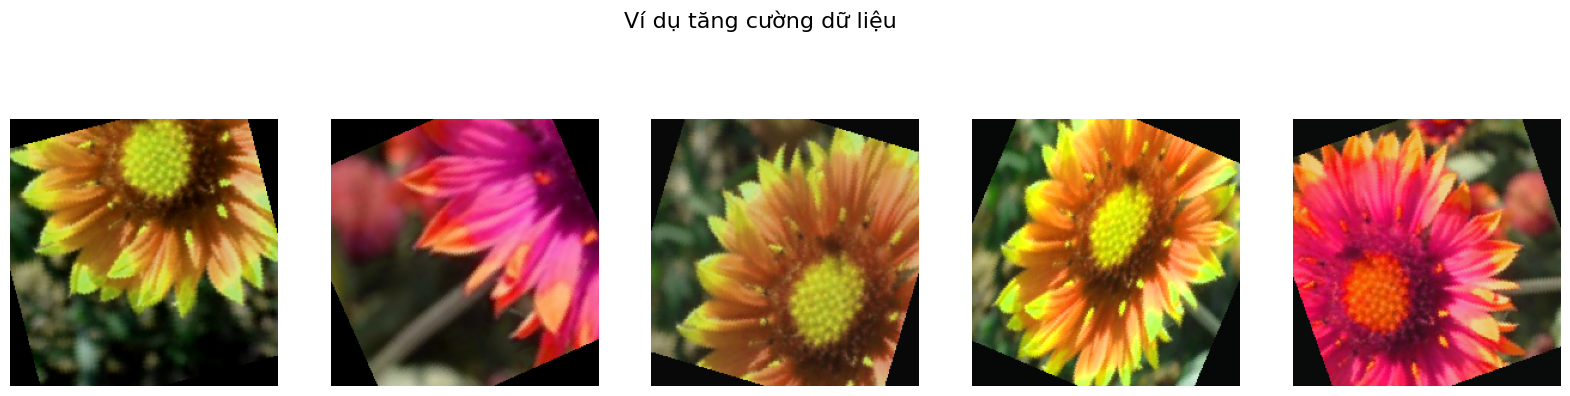

In [ ]:
#Tăng cường dữ liệu ảnh với torchvision
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random, os
img_dir = r"D:\archive\jpg\test"
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
if not img_files:
    print(f"❌ Không tìm thấy ảnh hợp lệ trong thư mục: {img_dir}")
else:
    sample_file = random.choice(img_files)
data_aug = transforms.Compose([
    transforms.Resize((256, 256)),               # Đổi kích thước trước
    transforms.RandomResizedCrop(224),          # Cắt ngẫu nhiên về 224x224
    transforms.RandomHorizontalFlip(p=0.5),     # Lật ngang ngẫu nhiên
    transforms.RandomRotation(25),              # Xoay ngẫu nhiên ±25°
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1), # Thay đổi độ sáng, tương phản, bão hòa
    transforms.ToTensor(),                      # Chuyển ảnh sang tensor [0,1]
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]) # Chuẩn hóa
])
if img_files:
    img_path = os.path.join(img_dir, sample_file)
    img = Image.open(img_path).convert('RGB')
    fig, axes = plt.subplots(1, 5, figsize=(20,5))
    fig.suptitle("Ví dụ tăng cường dữ liệu", fontsize=16)
    for i in range(5):
        aug_img = data_aug(img)  # Áp dụng augmentation
        # Chuyển tensor về ảnh để hiển thị (khử chuẩn hóa)
        img_np = aug_img.permute(1,2,0).numpy()
        img_np = (img_np * [0.229,0.224,0.225]) + [0.485,0.456,0.406]  # Khử chuẩn hóa
        img_np = img_np.clip(0,1)
        axes[i].imshow(img_np)
        axes[i].axis('off')
    plt.show()
plt.show()

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.
Found 819 validated image filenames.
Số lớp: 102


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [1]:
# 📊 Phân tích thống kê cơ bản dữ liệu ảnh
import os, random
from collections import Counter
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def analyze_image_dataset(data_dir, sample_images=200, save_csv=None):
    """
    Phân tích thống kê cơ bản dữ liệu ảnh + xuất DataFrame thống kê từng lớp.
    data_dir: thư mục chứa các thư mục con (mỗi thư mục con là một lớp).
    sample_images: số ảnh tối đa dùng để tính trung bình RGB.
    save_csv: đường dẫn CSV để lưu kết quả (nếu cần).
    """
    data_dir=os.path.abspath(data_dir)
    # 1. Đếm số lượng ảnh và lớp
    class_stats = []
    for cls in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls)
        if os.path.isdir(cls_path):
            img_files = [f for f in os.listdir(cls_path) if f.lower().endswith(('jpg','jpeg','png'))]
            count = len(img_files)
            widths, heights = [], []
            for img_name in img_files:
                img_path = os.path.join(cls_path, img_name)
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
            if widths and heights:
                class_stats.append({
                    "Class": cls,
                    "NumImages": count,
                    "MeanWidth": np.mean(widths),
                    "MeanHeight": np.mean(heights),
                    "MinWidth": np.min(widths),
                    "MinHeight": np.min(heights),
                    "MaxWidth": np.max(widths),
                    "MaxHeight": np.max(heights),
                })

    df_stats = pd.DataFrame(class_stats)
    print(f"🔹 Tổng số lớp: {len(df_stats)}")
    print(f"🔹 Tổng số ảnh: {df_stats['NumImages'].sum()}")
    display(df_stats.head())

    # Lưu ra CSV nếu cần
    if save_csv:
        df_stats.to_csv(save_csv, index=False)
        print(f"📂 Đã lưu thống kê ra: {save_csv}")

    # Vẽ phân bố số lượng ảnh theo lớp
    plt.figure(figsize=(12,4))
    plt.bar(df_stats["Class"], df_stats["NumImages"])
    plt.xticks(rotation=90)
    plt.ylabel("Số ảnh")
    plt.title("Phân bố số lượng ảnh theo lớp")
    plt.tight_layout()
    plt.show()

    # 2. Thống kê toàn bộ kích thước ảnh
    print(f"📏 Kích thước trung bình (toàn bộ): {df_stats['MeanWidth'].mean():.1f} x {df_stats['MeanHeight'].mean():.1f}")
    print(f"📏 Kích thước nhỏ nhất: {df_stats['MinWidth'].min()} x {df_stats['MinHeight'].min()}")
    print(f"📏 Kích thước lớn nhất: {df_stats['MaxWidth'].max()} x {df_stats['MaxHeight'].max()}")

    # 3. Thống kê giá trị pixel RGB
    means, stds = [], []
    counter = 0
    for cls in df_stats["Class"]:
        cls_path = os.path.join(data_dir, cls)
        for img_name in os.listdir(cls_path):
            if img_name.lower().endswith(('jpg','jpeg','png')):
                img_path = os.path.join(cls_path, img_name)
                img = np.array(Image.open(img_path).convert('RGB'))/255.0
                means.append(img.mean(axis=(0,1)))
                stds.append(img.std(axis=(0,1)))
                counter += 1
                if counter >= sample_images: break
        if counter >= sample_images: break
    mean_rgb = np.mean(means, axis=0)
    std_rgb = np.mean(stds, axis=0)
    print(f"🎨 Trung bình kênh RGB: {mean_rgb}")
    print(f"🎨 Độ lệch chuẩn kênh RGB: {std_rgb}")
    # 4. Phân tích sự mất cân bằng lớp
    plt.figure(figsize=(6,4))
    plt.hist(df_stats["NumImages"], bins=20, edgecolor='black')
    plt.xlabel("Số ảnh / lớp"); plt.ylabel("Số lớp")
    plt.title("Phân bố số ảnh trên mỗi lớp")
    plt.show()
    # 5. Hiển thị mẫu ảnh
    fig, axes = plt.subplots(2,5, figsize=(12,5))
    sample_classes = random.sample(list(df_stats["Class"]), min(5,len(df_stats)))
    for ax, cls in zip(axes.flatten(), sample_classes*2):
        cls_path = os.path.join(data_dir, cls)
        img_name = random.choice(os.listdir(cls_path))
        img_path = os.path.join(cls_path, img_name)
        img = Image.open(img_path)
        ax.imshow(img); ax.set_title(cls, fontsize=8); ax.axis('off')
    plt.suptitle("Mẫu ảnh từ các lớp", fontsize=14)
    plt.tight_layout()
    plt.show()
    return df_stats


d:\New folder (2)\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📊 Kết quả trên validation set:
Accuracy  : 0.9438
Precision : 0.9513
Recall    : 0.9438
F1-score  : 0.9436


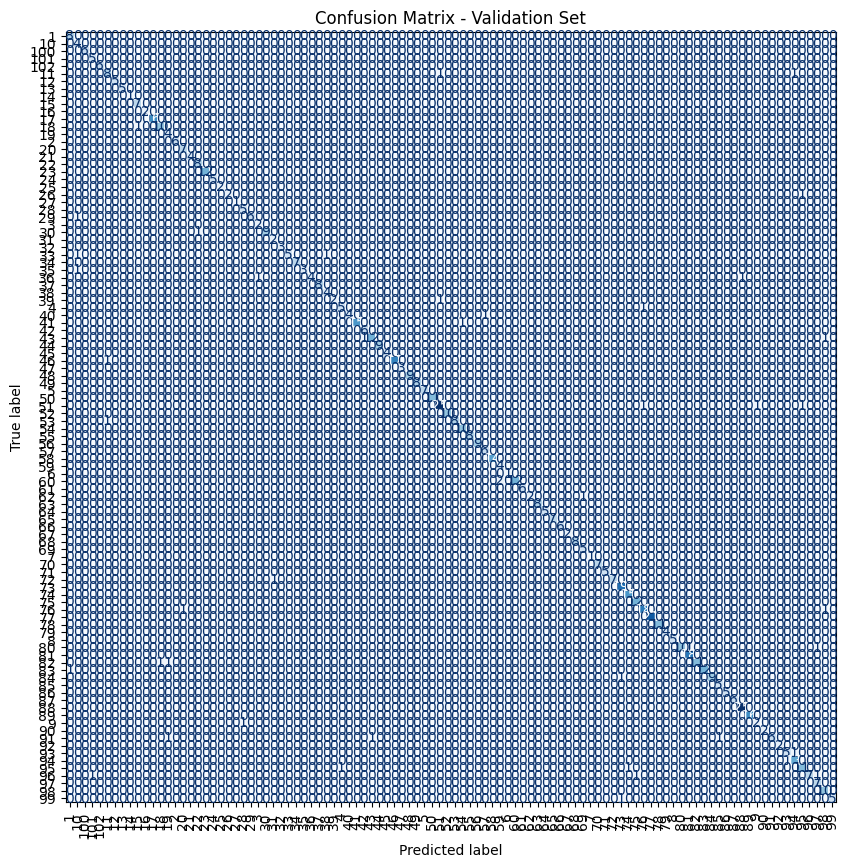

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np

# 🔹 Chuyển model sang eval mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 🔹 Tính các chỉ số
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("📊 Kết quả trên validation set:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")

# 🔹 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(train_ds.classes))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()



In [ ]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input
tf.keras.backend.clear_session()
# 📌 Đường dẫn dữ liệu
train_dir = "D:/archive/jpg/train/jpg"
valid_dir = "D:/archive/jpg/valid/jpg"
test_dir  = "D:/archive/jpg/test"
test_files = sorted([f for f in os.listdir(test_dir)])
df_test = pd.DataFrame({'filename': test_files})

# ⚙️ Tham số tối ưu cho laptop i7
img_size = (224,224)      # đồng bộ với EfficientNet
batch_size = 16           # giảm xuống 8 nếu RAM < 16GB

# 1️⃣ ImageDataGenerator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 2️⃣ Generator
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', color_mode='rgb'
)
val_gen = val_datagen.flow_from_directory(
    valid_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', color_mode='rgb'
)
test_gen = test_datagen.flow_from_dataframe(
    df_test,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=img_size,
    class_mode=None,
    shuffle=False,
    batch_size=batch_size,
    color_mode='rgb'
)

num_classes = train_gen.num_classes
print("Số lớp:", num_classes)

# 3️⃣ EfficientNetB0 base model (chuẩn, không lỗi)
base_model = EfficientNetB0(
    weights="imagenet",        # pretrained ImageNet
    include_top=False,
    input_shape=(224, 224, 3)  # 3 kênh RGB
)
base_model.trainable = False  # ban đầu đóng băng toàn bộ

# 4️⃣ Thêm lớp đầu ra
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# 5️⃣ Callback
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# 6️⃣ Huấn luyện giai đoạn 1 (feature extractor)
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=callbacks
)

# 7️⃣ Fine-tuning: mở 20–30 layer cuối
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_ft = model.fit(
    train_gen,
    epochs=8,
    validation_data=val_gen,
    callbacks=callbacks,
)

# 8️⃣ Dự đoán test
preds = model.predict(test_gen)
pred_classes = np.argmax(preds, axis=1)

# map chỉ số → tên class
inv_map = {v: k for k, v in train_gen.class_indices.items()}
pred_labels = [inv_map[c] for c in pred_classes]

# lấy tên file test
filenames = test_gen.filenames
ids = [os.path.basename(f) for f in filenames]

submission = pd.DataFrame({
    'id': ids,
    'class_id': pred_classes,
    'class_name': pred_labels
})
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv saved!")


Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.
Found 819 validated image filenames.
Số lớp: 102


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [10]:
# Debug + robust build script
import os, sys, traceback
import numpy as np, pandas as pd
from PIL import Image
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

print("Python:", sys.version.splitlines()[0])
print("TensorFlow:", tf.__version__)
try:
    import tensorflow.keras as keras
    print("Keras:", keras.__version__)
except:
    pass
try:
    import cv2
    print("cv2:", cv2.__version__)
except:
    pass
import numpy as np

# --- Paths (update nếu cần) ---
train_dir = r"D:/archive/jpg/train/jpg"
valid_dir = r"D:/archive/jpg/valid/jpg"
test_dir  = r"D:/archive/jpg/test"

# --- Quick image inspection (sample up to 100 files) ---
def inspect_folder(path, limit=100):
    files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    files = files[:limit]
    modes = {}
    sizes = []
    for f in files:
        p = os.path.join(path, f)
        try:
            with Image.open(p) as im:
                modes[im.mode] = modes.get(im.mode, 0) + 1
                sizes.append(im.size)
        except Exception as e:
            print("Cannot open", p, "->", e)
    print(f"Sampled {len(files)} files in {path}")
    print("Modes:", modes)
    if sizes:
        sizes = np.array(sizes)
        print("Width range:", sizes[:,0].min(), "-", sizes[:,0].max(),
              "Height range:", sizes[:,1].min(), "-", sizes[:,1].max())

for d in [train_dir, valid_dir, test_dir]:
    if os.path.isdir(d):
        # inspect only first class folder for train/valid if structure is class subfolders
        inspect_folder(d)
    else:
        print("Path not exist:", d)

# --- Parameters ---
img_size = (224,224)
batch_size = 16

# Ensure generators load RGB images
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20, width_shift_range=0.15,
                                   height_shift_range=0.15, zoom_range=0.15,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print("\nCreating generators (ensure color_mode='rgb') ...")
try:
    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', color_mode='rgb'
    )
    val_gen = val_datagen.flow_from_directory(
        valid_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', color_mode='rgb'
    )
    # for test folder with flat structure (many jpg files) use flow_from_dataframe:
    test_files = sorted([f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    df_test = pd.DataFrame({'filename': test_files})
    test_gen = test_datagen.flow_from_dataframe(
        df_test, directory=test_dir, x_col='filename', y_col=None,
        target_size=img_size, class_mode=None, shuffle=False, batch_size=batch_size, color_mode='rgb'
    )
except Exception as e:
    print("Error creating generators:", e)
    traceback.print_exc()
    raise

print("train_gen.image_shape:", getattr(train_gen, "image_shape", None))
print("train_gen.samples:", getattr(train_gen, "samples", None))
print("num_classes:", getattr(train_gen, "num_classes", None))

# --- Build model safely ---
def build_effnet(num_classes, input_shape=(224,224,3), weights='imagenet', local_weights_path=None):
    tf.keras.backend.clear_session()
    print("Building EfficientNetB0 with input_shape=", input_shape, "weights=", weights, "local_weights=", bool(local_weights_path))
    try:
        base = EfficientNetB0(weights=weights, include_top=False, input_shape=input_shape)
    except Exception as e:
        print("Failed to load base with weights=", weights, "->", e)
        # fallback: try without imagenet weights
        base = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)
        print("Fallback: created base with weights=None")
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    if local_weights_path:
        try:
            model.load_weights(local_weights_path)
            print("Local weights loaded OK.")
        except Exception as e:
            print("Cannot load local weights:", e)
            traceback.print_exc()
    return model

num_classes = train_gen.num_classes
# Ensure input shape has 3 channels
m = build_effnet(num_classes, input_shape=(img_size[0], img_size[1], 3), weights='imagenet', local_weights_path=None)
print("Model input shape:", m.input_shape)
print("Model summary (top 5 lines):")
for line in m.summary().splitlines()[:10] if hasattr(m, "summary") else ["(no summary)"]:
    print(line)

# Quick predict on one batch to ensure shapes align
x_batch, y_batch = next(train_gen)
print("Batch x shape:", x_batch.shape, "y shape:", y_batch.shape)
try:
    preds = m.predict(x_batch[:2])
    print("Predict ok, preds shape:", preds.shape)
except Exception as e:
    print("Error during predict on sample batch:", e)
    traceback.print_exc()
    raise


Python: 3.13.4 (tags/v3.13.4:8a526ec, Jun  3 2025, 17:46:04) [MSC v.1943 64 bit (AMD64)]
TensorFlow: 2.20.0
Keras: 3.11.3
cv2: 4.12.0
Sampled 0 files in D:/archive/jpg/train/jpg
Modes: {}
Sampled 0 files in D:/archive/jpg/valid/jpg
Modes: {}
Sampled 100 files in D:/archive/jpg/test
Modes: {'RGB': 100}
Width range: 500 - 810 Height range: 500 - 710

Creating generators (ensure color_mode='rgb') ...
Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.
Found 819 validated image filenames.
train_gen.image_shape: (224, 224, 3)
train_gen.samples: 6552
num_classes: 102

Building EfficientNetB0 with input_shape= (224, 224, 3) weights= imagenet local_weights= False
Failed to load base with weights= imagenet -> Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)
Fallback: created base with weights=None
Model input shape: (None, 224, 224, 3)
Model summary (top 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization_1[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,180,233 (15.95 MB)

 Trainable params: 4,138,210 (15.79 MB)

 Non-trainable params: 42,023 (164.16 KB)

AttributeError: 'NoneType' object has no attribute 'splitlines'